In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.qnn import TorchLayer
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

from avalanche.benchmarks.classic import SplitMNIST
from avalanche.training import CWRStar
from avalanche.training.plugins import EvaluationPlugin, LRSchedulerPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger
import pickle
import os

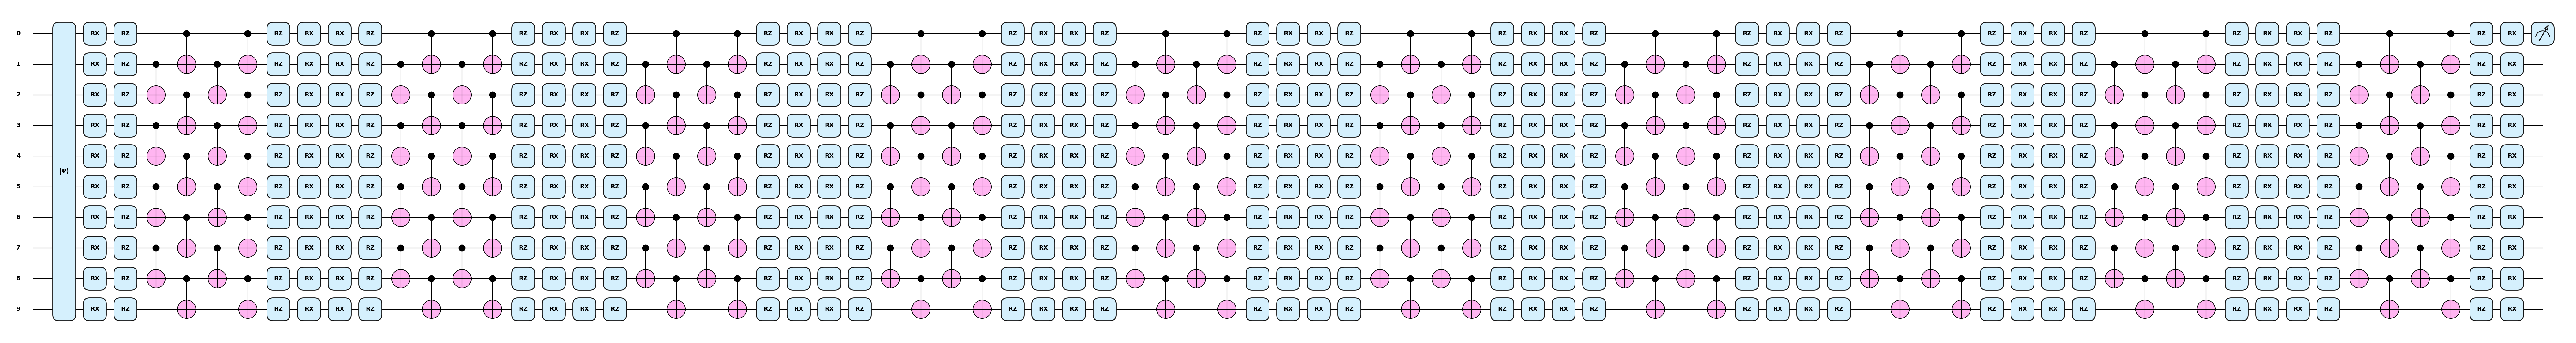

In [2]:
# -----------------------------
# 1. Quantum Circuit Definition (Multi-layer)
# -----------------------------
n_qubits = 10
input_dim = 2**n_qubits  # 28 x 28 MNIST
n_layers = 10  # ✅ Now actually used
dev = qml.device("lightning.qubit", wires=n_qubits)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def quantum_circuit(inputs, weights):
    # 💡 Clamp 限制输入范围，防止极端归一化后振幅很小或很大
    inputs = qml.math.clip(inputs, -1.0, 1.0)
    # 1. Amplitude embedding（必须 L2 归一化）
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True, pad_with=0.0)
    # weights: [n_layers, n_qubits, 2]
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RX(weights[layer, i, 1], wires=i)
            qml.RZ(weights[layer, i, 0], wires=i)

        # Entanglement layer (odd-even alternating)
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(n_qubits):
            qml.RZ(weights[layer, i, 0], wires=i)
            qml.RX(weights[layer, i, 1], wires=i)

    return qml.expval(qml.PauliZ(0))

qml.drawer.use_style("pennylane")
# 输入：8个量子比特
inputs = torch.randn(2 ** n_qubits)

# 权重：10 层，每层 8 比特，每比特两个参数（RZ, RX）
weights = torch.randn(n_layers, n_qubits, 2)

# 绘制电路
fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
plt.show()

In [3]:
# -----------------------------
# 2. TorchLayer + PyTorch Model
# -----------------------------

class QuantumClassifier(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        qnode = qml.QNode(quantum_circuit, dev, interface="torch")
        # TorchLayer 返回的张量默认在 CPU 上
        self.q_layer = TorchLayer(qnode, weight_shapes)
        # 经典层搬到你选的 device（比如 cuda:1）
        self.output = nn.Linear(1, 10).to(self.device)

    def forward(self, x):
        x = x.to(self.device)              # 把输入丢给 GPU（或 CPU）
        x = torch.nan_to_num(x, 0.0, 1.0, -1.0)
        x = F.normalize(x + 1e-8, p=2, dim=1)

        # 量子层模拟一定是在 CPU 上，结果也是 CPU tensor
        x = self.q_layer(x)
        # 这里把它搬到 self.device
        x = x.to(self.device)

        x = x.unsqueeze(1)
        x = self.output(x)
        return F.log_softmax(x, dim=1)

In [4]:
from torchvision import transforms

mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),      # 28×28 → 32×32
    # transforms.ToTensor(),            # [0,1]，shape=[1,32,32]
    transforms.Lambda(lambda x: x.view(-1))  # flatten 到 (1024,)
])

benchmark = SplitMNIST(
    n_experiences=5,
    return_task_id=False,
    train_transform=mnist_transform,
    eval_transform=mnist_transform
)

In [5]:
# -----------------------------
# 4. Avalanche EWC Strategy Setup
# -----------------------------

model = QuantumClassifier(device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss().to(device)

interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=10, save_image=True,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger]
)

In [ ]:
# 8. 添加学习率调度器
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
lr_plugin = LRSchedulerPlugin(lr_scheduler)

# 9. 创建持续学习策略
strategy = CWRStar(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    cwr_layer_name=None,    # None 表示自动使用模型最后一层
    train_mb_size=32,
    train_epochs=20,
    eval_mb_size=64,
    plugins=[lr_plugin],
    evaluator=eval_plugin,
    device=device
)

# 日志记录
interactive_logger = InteractiveLogger()
# text_logger = TextLogger(open('ewc_splitmnist.log', 'w'))
# tb_logger = TensorboardLogger('ewc_tb_logs')
strategy.evaluator.loggers = [interactive_logger]

/home/yangz2/anaconda3/envs/quan_cl/lib/python3.10/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


In [10]:
# -----------------------------
# 5. Training & Accuracy Recording
# -----------------------------
task_accuracies = []

for experience in benchmark.train_stream:
    print(f"\n--- Training on experience {experience.current_experience} ---")
    strategy.train(experience)

    print("--- Evaluating on test stream ---")
    results = strategy.eval(benchmark.test_stream)

    task_accuracies.append(results)


--- Training on experience 0 ---
-- >> Start of training phase << --
0it [00:00, ?it/s]

  1%|          | 1/100 [02:18<3:48:44, 138.63s/it]

KeyboardInterrupt: 

In [ ]:
# Define the file path
file_path = "/home/yangz2/code/quantum_cl/results/list/splitminist_CWRStar_ocf_qbit10_qdepth10.pkl"

# Create directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)  # <-- Add this line   

In [ ]:
# 存储到文件
with open(file_path, "wb") as f:
    pickle.dump([task_accuracies], f)  